In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter
from scipy import special

from conformal_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
logits = torch.load('data/imagenet_val/logits.pt')
labels = torch.load('data/imagenet_val/labels.pt')

# Convert to Numpy arrays
logits = logits.numpy()
labels = labels.type(torch.LongTensor).numpy()

### Some sanity checks

In [3]:
logits.shape

(50000, 1000)

In [4]:
labels.shape

(50000,)

In [5]:
min(labels), max(labels)

(0, 999)

In [6]:
# Check that there are 50 instances of each class
Counter(labels)

Counter({828: 50,
         800: 50,
         998: 50,
         782: 50,
         570: 50,
         900: 50,
         164: 50,
         776: 50,
         303: 50,
         967: 50,
         81: 50,
         779: 50,
         520: 50,
         441: 50,
         563: 50,
         849: 50,
         197: 50,
         885: 50,
         275: 50,
         615: 50,
         265: 50,
         196: 50,
         826: 50,
         464: 50,
         569: 50,
         131: 50,
         618: 50,
         969: 50,
         578: 50,
         507: 50,
         624: 50,
         510: 50,
         427: 50,
         997: 50,
         455: 50,
         2: 50,
         841: 50,
         866: 50,
         633: 50,
         973: 50,
         18: 50,
         613: 50,
         953: 50,
         202: 50,
         126: 50,
         596: 50,
         774: 50,
         302: 50,
         812: 50,
         96: 50,
         213: 50,
         860: 50,
         711: 50,
         516: 50,
         592: 50,
         314: 5

# Exploratory analysis

Use 5,000 instances as calibration and the remaining 45,000 as validation

1. Perform standard conformal inference and evaluate coverage
2. Perform class-balanced conformal inference and evaluate coverage


In [83]:
alpha = .1

In [84]:
np.random.seed(0)

# Convert logits to softmax vectors
softmax_scores = special.softmax(logits, axis=1)
scores = 1 - softmax_scores

# ======== SHUFFLE AND SPLIT DATA ======== 
split = 25000
idx = np.random.permutation(np.arange(len(labels)))
shuffled_logits = scores[idx]
shuffled_labels = labels[idx]
calib_scores, calib_labels = scores[:split], labels[:split]
val_scores, val_labels = scores[split:], labels[split:]

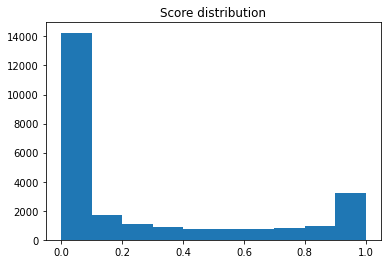

qhat: 0.9504131871128082
Standard conformal inference "marginal coverage": 89.69%


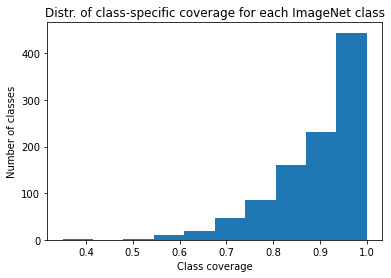

In [85]:
# ======== STANDARD CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
standard_ci_qhat = compute_qhat(calib_scores, calib_labels, alpha=alpha, plot_scores=True)
print('qhat:', standard_ci_qhat)
standard_ci_preds = create_prediction_sets(val_scores, standard_ci_qhat)

# --- Evaluate confidence sets ---
# i) Marginal coverage
marginal_cov = compute_coverage(val_labels, standard_ci_preds)
print(f'Standard conformal inference "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(val_labels, standard_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

One problem I am running into is that some classes do not appear in the calibration dataset or appear only a few times, which makes $\frac{\lceil(n+1)(1-\alpha)\rceil}{n} \geq 1$, which is not a valid quantile! I'm not sure what is the best approach for dealing with those classes. One option is to just use the non-class-specific quantile obtained from standard conformal inference. Another option is to set the quantile to $\infty$

Class-balanced conformal inference "marginal coverage": 92.13%


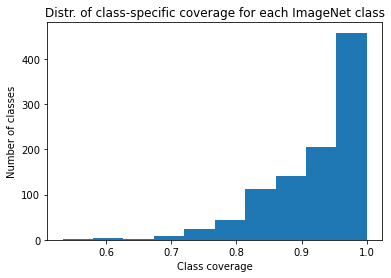

In [86]:
# ======== CLASS-BALANCED CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
default_qhat = standard_ci_qhat
qhats = compute_class_specific_qhats(calib_scores, calib_labels, alpha=alpha, default_qhat=np.inf)
# print('qhats:', qhats)
class_balanced_ci_preds = create_cb_prediction_sets(val_scores, qhats)

# --- Evaluate confidence sets ---
# i) Marginal coverage
cb_marginal_cov = compute_coverage(val_labels, class_balanced_ci_preds)
print(f'Class-balanced conformal inference "marginal coverage": {cb_marginal_cov*100:.2f}%')
# ii) Class-specific coverage
cb_class_specific_cov = compute_class_specific_coverage(val_labels, class_balanced_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(cb_class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

In [87]:
# plt.hist(calib_scores[2])

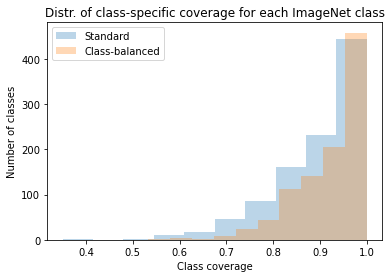

In [88]:
# Combine histograms into one plot

plt.hist(class_specific_cov, label="Standard", alpha=.3)
plt.hist(cb_class_specific_cov, label="Class-balanced", alpha=.3)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.legend()
plt.show()

In [89]:
np.mean(class_specific_cov)

0.8974466535417489

In [90]:
np.mean(cb_class_specific_cov)

0.9220716967787352

In [22]:
class_balanced_ci_preds

[array([225, 371, 478, 634]),
 array([402, 478, 486, 584, 600, 633, 634, 889]),
 array([ 20,  59,  78, 119, 126, 168, 170, 171, 180, 206, 208, 209, 221,
        225, 238, 246, 268, 296, 315, 371, 398, 403, 409, 412, 414, 434,
        436, 437, 459, 462, 478, 488, 501, 504, 519, 523, 534, 542, 543,
        549, 556, 575, 582, 584, 587, 589, 600, 615, 622, 623, 627, 632,
        633, 634, 650, 662, 663, 678, 681, 683, 692, 705, 716, 728, 742,
        745, 769, 770, 771, 782, 784, 787, 797, 798, 799, 811, 827, 828,
        830, 836, 837, 845, 868, 885, 898, 906, 911, 917, 918, 919, 920,
        951, 978, 999]),
 array([462, 478, 634, 669, 771]),
 array([315, 371, 409, 437, 478, 501, 575, 584, 589, 600, 615, 633, 634,
        665, 670, 716, 728, 919, 920]),
 array([152, 153, 315, 371, 478, 584, 634, 728]),
 array([117, 119, 238, 315, 371, 409, 437, 462, 470, 478, 488, 501, 504,
        506, 542, 549, 556, 584, 600, 627, 633, 634, 650, 663, 677, 699,
        710, 716, 728, 745, 753, 784, 79

In [23]:
standard_ci_preds

[array([225]),
 array([486, 889]),
 array([159, 168, 171, 178, 179, 180, 206, 209, 225, 243, 246, 268]),
 array([669]),
 array([665, 670]),
 array([153]),
 array([699]),
 array([238, 239, 240, 241]),
 array([10, 11]),
 array([785]),
 array([164, 166, 167]),
 array([718, 839]),
 array([333]),
 array([ 35,  36,  37, 119, 125, 305, 314, 316]),
 array([622, 732, 759]),
 array([436, 468, 555, 581, 609, 661, 705, 717, 864, 867]),
 array([460, 975, 978]),
 array([409, 826, 835, 880, 892]),
 array([540, 625, 628, 814]),
 array([947, 992]),
 array([543, 758]),
 array([508, 526, 527, 620, 664, 673, 681, 782]),
 array([544]),
 array([80]),
 array([411, 578, 614, 636, 692, 721, 748, 885, 887]),
 array([706, 799, 904, 905]),
 array([362]),
 array([488, 635, 679, 892]),
 array([200, 202, 226]),
 array([491, 600, 702, 733, 775, 840, 842, 913]),
 array([696]),
 array([415, 467, 582, 934, 963]),
 array([263, 264, 700, 805]),
 array([823]),
 array([453, 495, 548]),
 array([184, 274, 275, 276]),
 array([

We observe that the class-specific conformal inference approach is not doing as well as the standard conformal inference approach in terms of marginal coverage or class-specific coverage. This is likely because there is not enough data per class to get good class-specific quantile estimates. Or maybe there is a bug in my code? 

**TODO**: I think a good next step is to replicate these experiments using synthetic data (1000 classes, ~25 instances per class). Then compare against 1000 classes, ~100 instances per class to see if class-specific conformal inference will outperform standard conformal inference as the amount of data increases (which should cause the estimation error to decrease).